### Load Library

In [16]:
!pip install torch transformers datasets scikit-learn tqdm peft

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer,get_linear_schedule_with_warmup
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [18]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Dataset Loader

In [19]:
dataset = load_dataset("fancyzhx/amazon_polarity")

In [20]:
class AmazonPolarityDataset(Dataset):
  def __init__(self, data, tokenizer, max_length=256):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]
    text = item['content']

    encoding = self.tokenizer(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding='max_length',
      truncation=True,
      return_tensors='pt'
    )

    return {
      'input_ids': encoding['input_ids'].squeeze(),
      'attention_mask': encoding['attention_mask'].squeeze(),
      'labels': torch.tensor(item['label'], dtype=torch.long)
    }

In [21]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [22]:
train_subset = dataset['train'].select(range(100000))  # Use 100k samples
test_subset = dataset['test'].select(range(20000))    # Use 20k samples


train_dataset = AmazonPolarityDataset(train_subset, tokenizer)
test_dataset = AmazonPolarityDataset(test_subset, tokenizer)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

### Model

In [23]:
class T5ClassifierWithPEFT(nn.Module):
  def __init__(self, t5_model):
    super().__init__()

    # Load base T5 model
    self.t5 = t5_model

    # Configure LoRA
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=8,  # Rank
        lora_alpha=32,
        lora_dropout=0.1,
        target_modules=["q", "v"]  # Target query and value matrices
    )

    # Apply PEFT to the model
    self.t5 = get_peft_model(self.t5, peft_config)

    # Classification head
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(self.t5.config.d_model, 512)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(512, 2)
    self.logsm = nn.LogSoftmax(dim=1)

    # Print trainable parameters
    self.t5.print_trainable_parameters()

  def forward(self, input_ids, attention_mask):
    # Get the encoder outputs from T5
    encoder_outputs = self.t5.encoder(input_ids=input_ids, attention_mask=attention_mask)

    # Take the last hidden state
    last_hidden_state = encoder_outputs.last_hidden_state

    # Pool the outputs (mean pooling)
    pooled_output = torch.mean(last_hidden_state, dim=1)

    # Pass through classifier layers
    x = self.dropout(self.relu(self.fc1(pooled_output)))
    return self.logsm(self.fc2(x))

In [24]:
# Create the classifier with PEFT
model = T5ClassifierWithPEFT(t5_model)
model.to(device)

trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850


T5ClassifierWithPEFT(
  (t5): PeftModelForSeq2SeqLM(
    (base_model): LoraModel(
      (model): T5ForConditionalGeneration(
        (shared): Embedding(32128, 512)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 512)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear(
                      (base_layer): Linear(in_features=512, out_features=512, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=512, out_features=8, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=8, out_features=512, bias=False)
                      )

In [25]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = nn.NLLLoss()(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

In [26]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.NLLLoss()(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, predictions, actual_labels

In [27]:
# Setup optimizer and scheduler
# Only optimize the parameters that require gradients (LoRA and classification head)
EPOCHS = 5
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
num_training_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps * 0.1,
    num_training_steps=num_training_steps
)

In [28]:
# Plotting function for training metrics
import matplotlib.pyplot as plt
import seaborn as sns


def plot_training_metrics(train_losses, train_accuracies, eval_losses, eval_accuracies):
  # Set style
  sns.set_style("whitegrid")
  plt.figure(figsize=(15, 5))

  # Plot losses
  plt.subplot(1, 2, 1)
  epochs = range(1, len(train_losses) + 1)
  plt.plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
  plt.plot(epochs, eval_losses, 'r-', label='Validation Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.grid(True, alpha=0.3)

  # Plot accuracies
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', marker='o')
  plt.plot(epochs, eval_accuracies, 'r-', label='Validation Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
  plt.show()

# Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, class_names):
  from sklearn.metrics import confusion_matrix
  import seaborn as sns

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
  plt.show()

Starting training...

Epoch 1/5


Training: 100%|██████████| 3125/3125 [15:13<00:00,  3.42it/s]


Training Loss: 0.3023, Training Accuracy: 0.8672


Evaluating: 100%|██████████| 625/625 [01:25<00:00,  7.35it/s]


Evaluation Loss: 0.2147, Evaluation Accuracy: 0.9174

Epoch 2/5


Training: 100%|██████████| 3125/3125 [15:08<00:00,  3.44it/s]


Training Loss: 0.2131, Training Accuracy: 0.9161


Evaluating: 100%|██████████| 625/625 [01:25<00:00,  7.31it/s]


Evaluation Loss: 0.1991, Evaluation Accuracy: 0.9247

Epoch 3/5


Training: 100%|██████████| 3125/3125 [15:09<00:00,  3.44it/s]


Training Loss: 0.1971, Training Accuracy: 0.9225


Evaluating: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


Evaluation Loss: 0.1924, Evaluation Accuracy: 0.9282

Epoch 4/5


Training: 100%|██████████| 3125/3125 [15:07<00:00,  3.44it/s]


Training Loss: 0.1868, Training Accuracy: 0.9268


Evaluating: 100%|██████████| 625/625 [01:25<00:00,  7.34it/s]


Evaluation Loss: 0.1939, Evaluation Accuracy: 0.9278

Epoch 5/5


Training: 100%|██████████| 3125/3125 [15:07<00:00,  3.45it/s]


Training Loss: 0.1792, Training Accuracy: 0.9295


Evaluating: 100%|██████████| 625/625 [01:24<00:00,  7.36it/s]


Evaluation Loss: 0.1933, Evaluation Accuracy: 0.9291


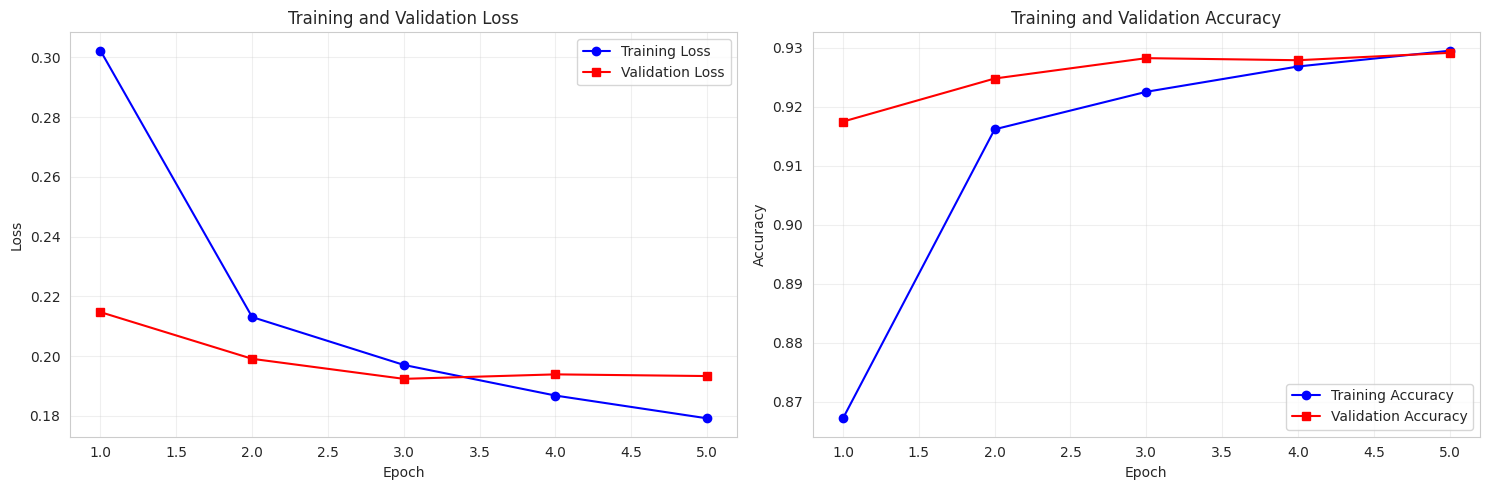

Evaluating: 100%|██████████| 625/625 [01:24<00:00,  7.37it/s]



Final Evaluation:
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      9786
    Positive       0.94      0.92      0.93     10214

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



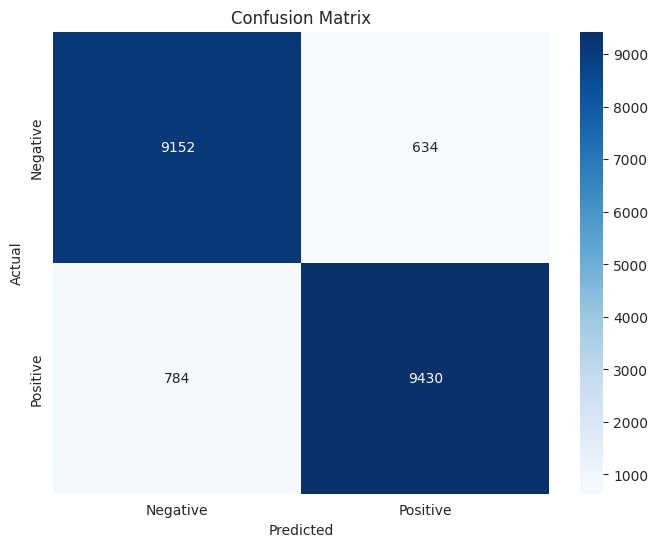


Model saved as 'T5_sentiment_classifier_peft_final.pth'


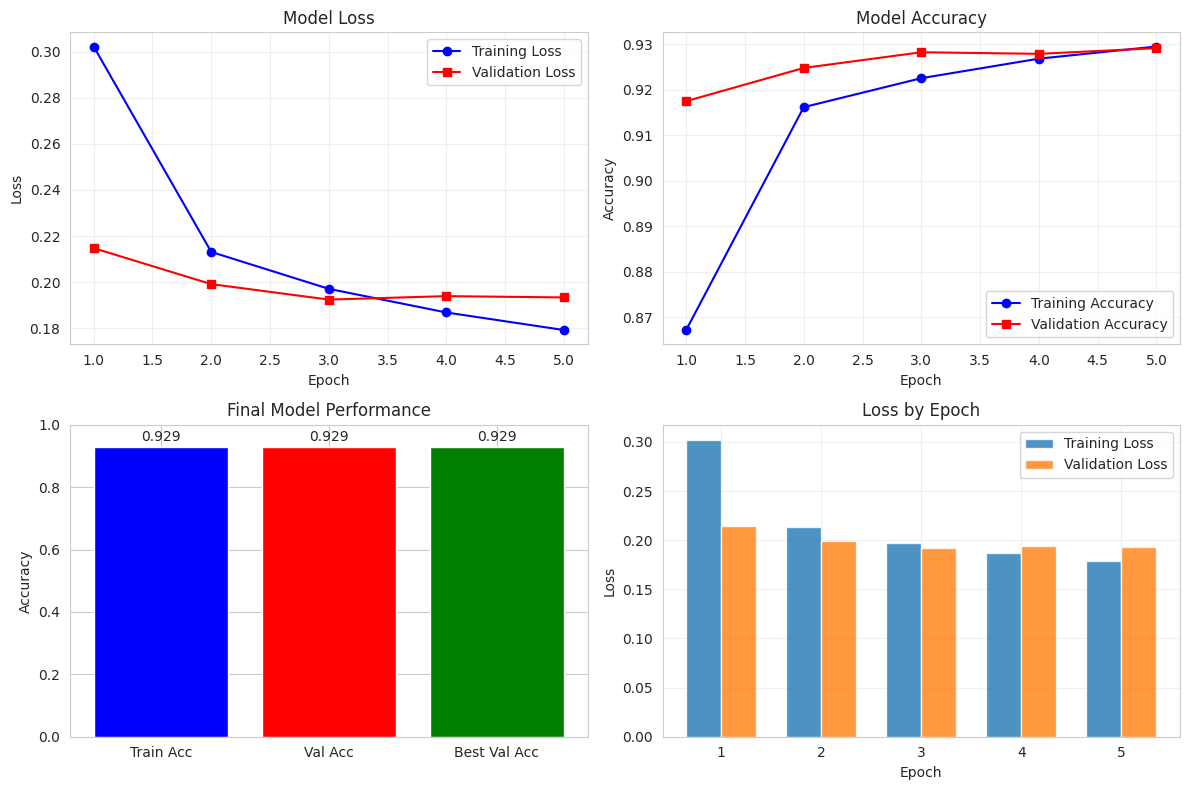

In [29]:
# Training loop
print("Starting training...")
best_accuracy = 0

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    eval_loss, eval_acc, predictions, actual_labels = evaluate(model, test_dataloader, device)
    print(f"Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_acc:.4f}")

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_acc)

    # Save the best model
    if eval_acc > best_accuracy:
        best_accuracy = eval_acc
        torch.save(model.state_dict(), 'T5_sentiment_classifier_peft_best.pth')

# Plot training metrics
plot_training_metrics(train_losses, train_accuracies, eval_losses, eval_accuracies)

# Load best model for final evaluation
model.load_state_dict(torch.load('T5_sentiment_classifier_peft_best.pth'))
_, _, predictions, actual_labels = evaluate(model, test_dataloader, device)

# Final evaluation with classification report
print("\nFinal Evaluation:")
print(classification_report(actual_labels, predictions, target_names=['Negative', 'Positive']))

# Plot confusion matrix
plot_confusion_matrix(actual_labels, predictions, ['Negative', 'Positive'])

# Save the final model
torch.save(model.state_dict(), 'T5_sentiment_classifier_peft_final.pth')
print("\nModel saved as 'T5_sentiment_classifier_peft_final.pth'")

# Create a comprehensive results plot
plt.figure(figsize=(12, 8))

# Loss subplot
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', label='Training Loss')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, 'r-s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy subplot
plt.subplot(2, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, 'r-s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Bar chart for final metrics
plt.subplot(2, 2, 3)
metrics = ['Train Acc', 'Val Acc', 'Best Val Acc']
values = [train_accuracies[-1], eval_accuracies[-1], best_accuracy]
bars = plt.bar(metrics, values, color=['blue', 'red', 'green'])
plt.ylabel('Accuracy')
plt.title('Final Model Performance')
plt.ylim(0, 1.0)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom')

# Training progress summary
plt.subplot(2, 2, 4)
epochs = list(range(1, len(train_losses) + 1))
width = 0.35
x = np.arange(len(epochs))

plt.bar(x - width/2, train_losses, width, label='Training Loss', alpha=0.8)
plt.bar(x + width/2, eval_losses, width, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.xticks(x, epochs)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_summary.png', dpi=300, bbox_inches='tight')
plt.show()